## 1. 필요한 패키지 불러오기

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import cv2

## 2. 데이터 불러오기

In [2]:
cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(f"훈련 데이터 입력 변수   : {x_train.shape}")
print(f"훈련 데이터 출력 변수   : {y_train.shape}")
print("\n")
print(f"테스트 데이터 입력 변수   : {x_test.shape}")
print(f"테스트 데이터 출력 변수   : {y_test.shape}")

170500096/170498071 [==============================] - 3s 0us/step
훈련 데이터 입력 변수   : (50000, 32, 32, 3)
훈련 데이터 출력 변수   : (50000, 1)


테스트 데이터 입력 변수   : (10000, 32, 32, 3)
테스트 데이터 출력 변수   : (10000, 1)


### 특정 레이블만 뽑아서 DCGAN 해보기

In [3]:
from collections import Counter
print(Counter(y_train.reshape(-1)))

label = 4
part_x_train = x_train[(y_train == label).reshape(-1), :, :, :]
part_x_test = x_test[(y_test == label).reshape(-1), :, :, :]

batch_size = 64

train_buffer_size = len(part_x_train)
x_train_dataset = tf.data.Dataset.from_tensor_slices(part_x_train)
x_train_dataset = x_train_dataset.shuffle(train_buffer_size)
x_train_dataset = x_train_dataset.batch(batch_size)

test_buffer_size = len(part_x_test)
x_test_dataset = tf.data.Dataset.from_tensor_slices(part_x_test)
x_test_dataset = x_test_dataset.shuffle(test_buffer_size)
x_test_dataset = x_test_dataset.batch(batch_size)

Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})


In [4]:
batch_size = 64

train_buffer_size = len(x_train)
x_train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
x_train_dataset = x_train_dataset.shuffle(train_buffer_size)
x_train_dataset = x_train_dataset.batch(batch_size)

test_buffer_size = len(x_test)
x_test_dataset = tf.data.Dataset.from_tensor_slices(x_test)
x_test_dataset = x_test_dataset.shuffle(test_buffer_size)
x_test_dataset = x_test_dataset.batch(batch_size)

## 3. 데이터 살펴보기

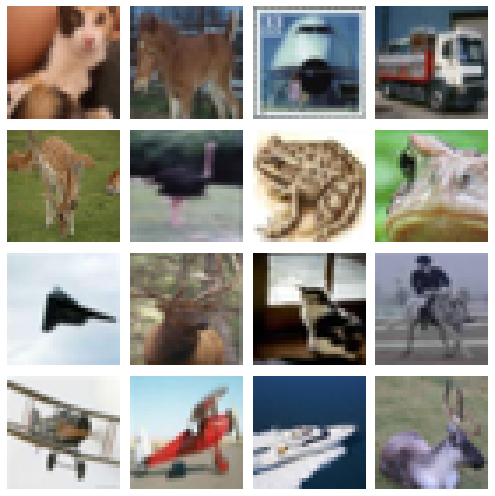

In [5]:
tmp = next(iter(x_train_dataset))
fig, axes = plt.subplots(4, 4, figsize = (7, 7))
axes = axes.ravel()
for ind, axis in enumerate(axes):
    axis.imshow(tmp[ind])
    axis.axis("off")

plt.tight_layout()
plt.show()

In [6]:
x_train_dataset = x_train_dataset.map(lambda x: (tf.cast(x, tf.float32) - 127.5 ) / 127.5)
x_test_dataset = x_test_dataset.map(lambda x:  (tf.cast(x, tf.float32) - 127.5) / 127.5)

## 4. 모델 구축하기

### 생성자 모델 구축

In [7]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 64)        2

### 생성자에 들어가는 노이즈 확인

생성자 노이즈 shape : (1, 32, 32, 3)


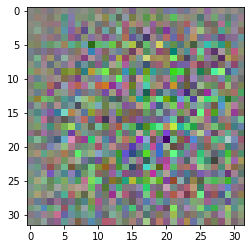

In [8]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(f"생성자 노이즈 shape : {generated_image.shape}")

tmp = generated_image.numpy()[0]
tmp = (tmp - np.min(tmp)) / (np.max(tmp) - np.min(tmp))
plt.imshow(tmp)
plt.show()

### 판별자 모델 구축

In [9]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model


discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

### 판별자에 들어가는 노이즈 확인

In [10]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00114403]], dtype=float32)>

### model.compile 설정 (loss, optimizer, 생성자 노이즈)

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# BinaryCrossEntorpy인 이유 이진분류이기 때문

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

In [14]:
noise_dim = 100
num_examples_to_generate = batch_size

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([64, 100])

### 모델 학습 구조 설계

In [15]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([batch_size, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        
        #(4) generated_images 생성
        generated_images = generator(noise, training=True)  
        
        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

### 모델 학습 결과 시각화

In [16]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    
    predictions = model(sample_seeds, training=False)
    
    pred_np = predictions.numpy()
    minmax_np = (pred_np - np.min(pred_np)) / (np.max(pred_np) - np.min(pred_np))
    
    fig = plt.figure(figsize=(6, 6))
    for i in range(predictions.shape[0]):
        plt.subplot(round(np.sqrt(batch_size)), round(np.sqrt(batch_size)), i+1)
        plt.imshow(minmax_np[i, :, :, :])
        plt.axis('off')
   
    plt.savefig('./models/images/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))

    plt.show()

In [17]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 6, 6

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('./models/model_eval_image/train_history_{:04d}.png'.format(epoch))
    plt.show()

### 모델 학습 설계 및 체크포인트 설정

In [18]:
checkpoint_dir = "./models/training_checkpoint"

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [19]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

### 모델 학습 시작

In [47]:
save_every = 5
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

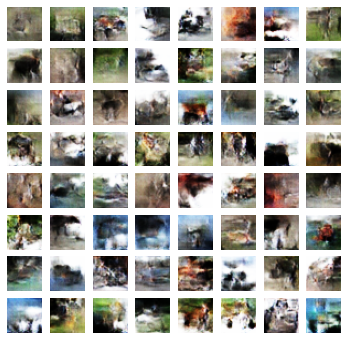

Time for training : 8234 sec


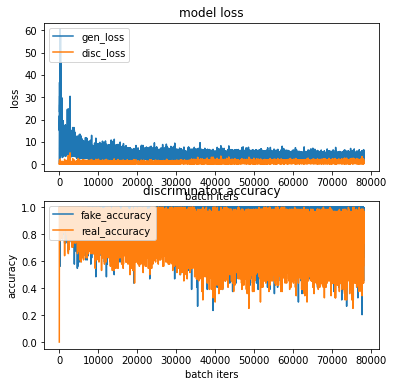

CPU times: user 1h 36min 54s, sys: 59.8 s, total: 1h 37min 53s
Wall time: 2h 17min 17s


In [48]:
%%time
train(x_train_dataset, EPOCHS, save_every)

### 결과 확인을 위한 .gif 제작

In [20]:
import PIL
import imageio
import glob
# 이미지 관련 패키지

anim_file = './fashion_cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./models/images/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [21]:
!ls -l ./fashion_cifar10_dcgan.gif

-rw-r--r-- 1 root root 7862313 Nov 15 01:19 ./fashion_cifar10_dcgan.gif


### 학습된 체크포인트 불러오기

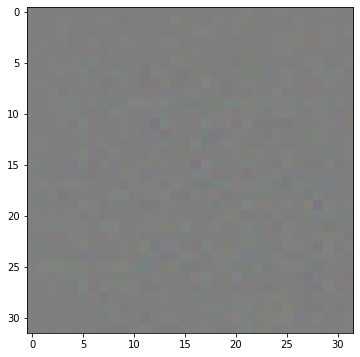

In [26]:
checkpoint_dir = './models/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

참고 사이트
- https://github.com/4thgen/DCGAN-CIFAR10
- https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/